In [1]:
%cd /home/is/dwipraseetyo-a/NAS_HAI/Project/Qwen2.5-Omni
%pwd

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"
print("CUDA_VISIBLE_DEVICES:", os.environ["CUDA_VISIBLE_DEVICES"])

import torch
device_name = torch.cuda.get_device_name(0)
for i in range(torch.cuda.device_count()):
    props = torch.cuda.get_device_properties(i)
    print(f"Logical index: {i}, Name: {props.name}")

from qwen_mywrapper import get_OmniModel, get_stoppingcrit
from qwen_omni_utils import process_mm_info
import pandas as pd
from tqdm import tqdm

from transformers import StoppingCriteria, StoppingCriteriaList, Qwen2_5OmniThinkerForConditionalGeneration, Qwen2_5OmniProcessor, BitsAndBytesConfig
import torch

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import const_variable
import commons
import random
random.seed(42)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

class QwenOmniFinetuneDataset(Dataset):
    def __init__(self, data, processor, use_audio_in_video=False):
        self.data = data
        self.processor = processor
        self.use_audio_in_video = use_audio_in_video

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        conversation = self.data[idx]["messages"]
        return conversation

import random, copy
import torch
from torch.utils.data import DataLoader

def collate_fn(batch):
    texts, gold_answers = [], []
    for conversation in batch:
        now_conv = copy.deepcopy(conversation)
        gold_answers.append(now_conv[2])  # save real answer
        del now_conv[2]  # remove the real answer for generation

        text = processor.apply_chat_template(now_conv, add_generation_prompt=True, tokenize=False)
        texts.append(text)

    audios, images, videos = process_mm_info(batch, use_audio_in_video=False)
    batch_inputs = processor(text=texts, audio=audios, images=images, videos=videos, 
                            return_tensors="pt", padding=True, use_audio_in_video=False)

    batch_inputs['use_audio_in_video'] = False
    batch_inputs['gold_answers'] = gold_answers
    return batch_inputs

/home/ldap-users-2/dwipraseetyo-a/Project/Qwen2.5-Omni
CUDA_VISIBLE_DEVICES: 0, 1
Logical index: 0, Name: NVIDIA GeForce RTX 3090
Logical index: 1, Name: NVIDIA GeForce RTX 3090


In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)

model = Qwen2_5OmniThinkerForConditionalGeneration.from_pretrained("outputs/qwen25omni-3b-instructMedic-Reason-notallpresent-llmimagellmsymp-trl-sft/checkpoint-3000",
            torch_dtype="auto",
            device_map="auto",  
            quantization_config=bnb_config, 
            attn_implementation="flash_attention_2",
            offload_folder="offload", # Offload weights to CPU if needed
        )
model.eval()
processor = Qwen2_5OmniProcessor.from_pretrained("Qwen/Qwen2.5-Omni-3B")

stopping_criteria = get_stoppingcrit(processor)

In [2]:
DATA_PATH = "/home/is/dwipraseetyo-a/NAS_HAI/Datasets/cidrz"

In [ ]:
df = pd.read_csv(f"{DATA_PATH}/metadata_cut_processed.csv.test")
df_llm_symptoms = ( pd.read_csv(f"{DATA_PATH}/llm_analyze_symptoms.csv.test").groupby('barcode', group_keys=False).apply(lambda x: x.sample(1), include_groups=True).reset_index(drop=True) ) 
df_llm_images = ( pd.read_csv(f"{DATA_PATH}/llm_analyze_image_formatted.csv.test").groupby('path_file_image', group_keys=False).apply(lambda x: x.sample(1), include_groups=True).reset_index(drop=True) )
df = pd.merge(df, df_llm_symptoms, on='barcode', how='left')
df = pd.merge(df, df_llm_images, on='path_file_image', how='left')
df = df.rename(columns={'coughdur': 'cough_duration', 'ngtsweats': 'night_sweets', 'weightloss': 'weight_loss', 'body_wt': 'body_weight'})

instruct_array_positive = []
instruct_array_negative = []

for now_row in tqdm(df.itertuples(), desc=f"Processing Datasets", total=len(df)):
    row_dict = now_row._asdict()
    now_audiopath = "/home/is/dwipraseetyo-a/NAS_HAI/Datasets/cidrz/" +  now_row.path_file_audio
    now_imgaepath = "/home/is/dwipraseetyo-a/NAS_HAI/Datasets/cidrz/" +  now_row.path_file_image

    modalities = ["audio", "xray", "symptoms"]
    key = tuple(modalities)
    if key in const_variable.prompt_templates:
        question = random.choice(const_variable.prompt_templates[key]) + ". "
    answer = commons.generate_tb_response(modalities, now_row.llm_analyze_symptoms, now_row.llm_analyze_image, positive=(now_row.ground_truth_tb == 1))

    array_df = [None, None]
    if "symptoms" in modalities:
        row_dict = now_row._asdict()
        selected_feats = random.sample(const_variable.columns_soundfeat, k=random.randint(3, len(const_variable.columns_soundfeat)))
        symptom_descriptions = ", ".join(
            f"{feat.replace('_', ' ')} is {row_dict[feat]}"
            for feat in selected_feats
            if row_dict.get(feat) != "Unknown"
        )
        if symptom_descriptions:
            question += f" Also, the patient presents with: {symptom_descriptions}."

    if "audio" in modalities:
        array_df[0] = now_audiopath

    if "xray" in modalities:
        array_df[1] = now_imgaepath
        xray_descriptions = ", ".join(
            f"{feat.replace('_', ' ')} is {row_dict[feat]}"
            for feat in const_variable.columns_imagefeat
            if row_dict.get(feat) != "Unknown"
        )
        if xray_descriptions:
            question += f" Additional chest x-ray metadata include: {xray_descriptions}."

    question = question.strip()
    question = question.rstrip(",.")
    if not question.endswith("."):
        question += "."

    temp_instruct = {"messages": [
        {"role": "system",
            "content": [
                {"type": "text", "text": "You are an advanced medical assistant AI specialized in analyzing and diagnosing clinical conditions. You can interpret and reason over various medical inputs, including cough sounds, chest X-rays, and patient metadata, individually or in combination, depending on what is provided. Your task is to analyze the given information, explain your reasoning clearly, and provide possible diagnoses based on medical understanding. Support your conclusions with observations from the input data whenever possible, and maintain clinical accuracy and clarity in your responses."}
            ],
        },
        {
            "role": "user",
            "content": [
                {"type": "text", "text": question},
            ],
        },
        {"role": "assistant", "content": [
            {"type": "text", "text": answer}]},
    ]}
    if array_df[0] != None:
        temp_instruct["messages"][1]['content'].append({"type": "audio", "audio": array_df[0]})
    if array_df[1] != None:
        temp_instruct["messages"][1]['content'].append({"type": "image", "image":array_df[1]})

    if now_row.ground_truth_tb == 1:
        instruct_array_positive.append(temp_instruct)
    elif now_row.ground_truth_tb == 0:
        instruct_array_negative.append(temp_instruct)
        
test_instruct = commons.load_image_PIL(instruct_array)
test_dataset = QwenOmniFinetuneDataset(test_instruct, processor, use_audio_in_video=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:25<00:00,  5.00it/s]


In [ ]:
 {'messages': [{'role': 'system',
    'content': [{'type': 'text',
      'text': 'You are an advanced medical assistant AI specialized in analyzing and diagnosing clinical conditions. '
      'You can interpret and reason over various medical inputs, including cough sounds, chest X-rays, and patient metadata, individually or in combination, depending on what is provided.'
      ' Your task is to analyze the given information, explain your reasoning clearly, and provide possible diagnoses based on medical understanding. '
      'Support your conclusions with observations from the input data whenever possible, and maintain clinical accuracy and clarity in your responses.'}]},
   {'role': 'user',
    'content': [{'type': 'text',
      'text': 'Given the combined evidence, does this case represent tuberculosis?.  '
      'Also, the patient presents with: chestpain is yes, cigarretes perday is 1-10, night sweets is yes, haemoptysis is no, height is 162.0, weight loss is yes, bmi is 17.0, hiv status is neg, cough duration is >4weeks, sex is m, body weight is 44.0, fever is yes, shortbreath is yes.'
      'Additional chest x-ray metadata include: Modality is DX, DistanceSourceToDetector is 1000.0, FieldOfViewDimensions is [350, 425], ImagerPixelSpacing is [0.15, 0.15], TargetExposureIndex is 876.0, Sensitivity is 938.0, PhotometricInterpretation is MONOCHROME1, Rows is 2336, Columns is 2836, PixelIntensityRelationshipSign is 1, WindowCenter is 1469.0, WindowWidth is 4095.0, RescaleIntercept is 0.0, RescaleSlope is 1.0.'},
     {'type': 'audio',
      'audio': '/home/is/dwipraseetyo-a/NAS_HAI/Datasets/cidrz/wavs/01-399-0803.wav'},
     {'type': 'image',
      'image': <PIL.Image.Image image mode=L size=2337x2150>}]},
   {'role': 'assistant',
    'content': [{'type': 'text',
      'text': "From the given symptoms, cough sound, and x-ray, Let me Analyze your regrading your questions.\n\n*   "
      "All modalities are present.\nThis is a preliminary interpretation based on given data and does not replace a comprehensive clinical evaluation.. "
      "A definitive diagnosis requires a additional clinical evaluation, including the physical examination findings, Cough Sound, Auscultation Sound, and imaging studies.\n## 🧠 Overview\nbased on the findings, Tuberculosis is the most likely diagnosis.\n\n## 📋 Observations\n**Symptoms:**\n*   The symptoms presented in this case are highly suggestive of tuberculosis (TB). The key indicators include a prolonged cough duration of more than four weeks, which aligns with the chronicity seen in TB cases. A productive cough further raises the suspicion, as TB often leads to the production of sputum, especially when pulmonary involvement is significant. The presence of chest pain and shortness of breath can indicate lung involvement, which is common in TB cases due to the inflammation and damage to lung tissues. Additionally, systemic symptoms like fever, night sweats, and weight loss are classic manifestations of TB, as the infection invokes an immune response that often presents with these features. The patient's low body mass index (BMI of 17.0) indicates malnutrition, which can further compromise immune function and is a concern in TB, where nutritional deficits are often seen. The negative HIV status reduces the likelihood of opportunistic infections; however, it does not exclude TB as a diagnosis, particularly in individuals who may be immunocompromised due to other factors. Tobacco use is an independent risk factor that can exacerbate respiratory illnesses and may contribute to lung pathology but is not a direct link to TB itself. Overall, the symptom pattern aligns with typical presentations of pulmonary tuberculosis.\n\n**Chest X-ray:**\n* Key Features\n    *   **Interstitial Infiltrates:** The most prominent finding is the presence of interstitial infiltrates, particularly in the upper lobes. These appear as hazy opacities within the lung parenchyma, often with a reticular or nodular pattern. This pattern is highly suggestive of tuberculosis.\n    *   **Cavitation:** Cavitary lesions are also present, particularly in the upper lobes. These are characterized by areas of air-filled space within the lung parenchyma, often surrounded by a thick, well-defined wall. Cavitation is a common feature of TB, especially in reactivation disease.\n    *   **Fibrotic Changes:** There may be evidence of fibrotic changes, such as pleural thickening or reticular opacities in the lung parenchyma. These findings can be seen in chronic or advanced TB.\n    *   **Lymphadenopathy:** Enlarged lymph nodes (lymphadenopathy) may be present, particularly in the hilar regions. This can be a sign of TB infection. \n\nThe chest X-ray findings are highly suggestive of tuberculosis. The presence of interstitial infiltrates, cavitation, and potentially fibrotic changes in the upper lobes, along with possible lymphadenopathy, strongly points towards this diagnosis. Further evaluation, such as sputum cultures and/or a biopsy, is recommended to confirm the diagnosis and determine the specific type of TB. \n\n\n**Audio:**\n*   Will be Implemented Soon"}]}]},

In [7]:
test_loader = DataLoader(
    test_dataset,
    batch_size=5, shuffle=False,
    collate_fn=collate_fn
)

In [8]:
generated_texts = []
reference_texts = []
for batch in tqdm(test_loader):
    gold_answers = batch.pop('gold_answers')
    batch = {
        k: (v.to(model.device).to(model.dtype) if v.dtype.is_floating_point else v.to(model.device))
        if torch.is_tensor(v) else v
        for k, v in batch.items()
    }

    with torch.no_grad(), torch.amp.autocast('cuda'):
        generation = model.generate(
            **batch,
            stopping_criteria=stopping_criteria,
            max_new_tokens=768,
        )
        generate_ids = generation[:, batch["input_ids"].size(1):]

    decoded = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    generated_texts.extend(decoded)
    for gold_answer in gold_answers:
        reference_texts.append(gold_answer['content'][0]['text'])

    del generation, generate_ids, batch
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [55:52<00:00, 128.93s/it]


In [21]:
import re
import const_variable
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
labe_gen, label_original = [], []
for generated_text in generated_texts:
    match = re.search(r"## 🧠 Overview\n(.*?)\n\n##", generated_text, re.DOTALL)
    sentence = match.group(1).strip() if match else None
    if sentence in const_variable.positive_templates:
        labe_gen.append(1)
    elif sentence in const_variable.negative_templates:
        labe_gen.append(0)
    else:
        labe_gen.append(None)

for reference_text in reference_texts:
    match = re.search(r"## 🧠 Overview\n(.*?)\n\n##", reference_text, re.DOTALL)
    sentence = match.group(1).strip() if match else None
    if sentence in const_variable.positive_templates:
        label_original.append(1)
    elif sentence in const_variable.negative_templates:
        label_original.append(0)
    else:
        label_original.append(None)

Accuracy: 0.827
Sensitivity: 0.000
Specificity: 1.000


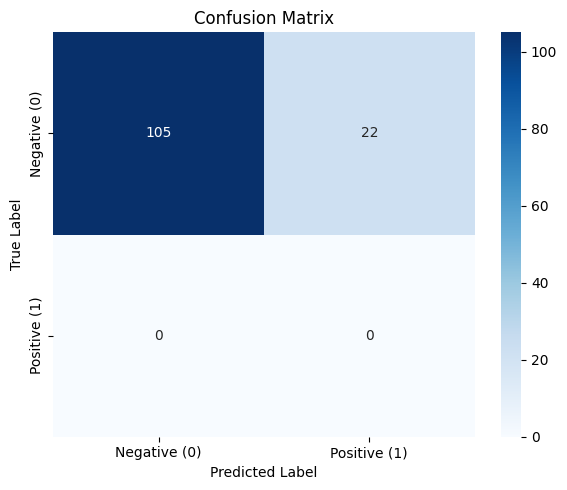

In [22]:
accuracy = accuracy_score(label_original, labe_gen)
tn, fp, fn, tp = confusion_matrix(label_original, labe_gen).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Accuracy: {accuracy:.3f}")
print(f"Sensitivity: {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")

cm = confusion_matrix(labe_gen, label_original)
labels = ['Negative (0)', 'Positive (1)']

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
from bert_score import score

P = generated_texts # predicted
R = reference_texts # reference

P, R, F1 = score(P, R, lang="en", verbose=True, nthreads=10)
print("BERTScore F1:", F1[0].item())

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.08s/it]


computing greedy matching.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 17.03it/s]

done in 4.48 seconds, 28.32 sentences/sec
BERTScore F1: 0.9462870955467224


In [11]:
from IPython.display import Audio, Markdown, display

In [12]:
display(Markdown("From the given symptoms, cough sound, and x-ray, Let me Analyze your regrading your questions.\n\n*   All modalities are present.\nThis is a preliminary interpretation based on given data and does not replace a comprehensive clinical evaluation.. A definitive diagnosis requires a additional clinical evaluation, including the physical examination findings, Cough Sound, Auscultation Sound, and imaging studies.\n## 🧠 Overview\nbased on the findings, Tuberculosis is the most likely diagnosis.\n\n## 📋 Observations\n**Symptoms:**\n*   The symptoms presented in this case are highly suggestive of tuberculosis (TB). The key indicators include a prolonged cough duration of more than four weeks, which aligns with the chronicity seen in TB cases. A productive cough further raises the suspicion, as TB often leads to the production of sputum, especially when pulmonary involvement is significant. The presence of chest pain and shortness of breath can indicate lung involvement, which is common in TB cases due to the inflammation and damage to lung tissues. Additionally, systemic symptoms like fever, night sweats, and weight loss are classic manifestations of TB, as the infection invokes an immune response that often presents with these features. The patient's low body mass index (BMI of 17.0) indicates malnutrition, which can further compromise immune function and is a concern in TB, where nutritional deficits are often seen. The negative HIV status reduces the likelihood of opportunistic infections; however, it does not exclude TB as a diagnosis, particularly in individuals who may be immunocompromised due to other factors. Tobacco use is an independent risk factor that can exacerbate respiratory illnesses and may contribute to lung pathology but is not a direct link to TB itself. Overall, the symptom pattern aligns with typical presentations of pulmonary tuberculosis.\n\n**Chest X-ray:**\n* Key Features\n    *   **Interstitial Infiltrates:** The most prominent finding is the presence of interstitial infiltrates, particularly in the upper lobes. These appear as hazy opacities within the lung parenchyma, often with a reticular or nodular pattern. This pattern is highly suggestive of tuberculosis.\n    *   **Cavitation:** Cavitary lesions are also present, particularly in the upper lobes. These are characterized by areas of air-filled space within the lung parenchyma, often surrounded by a thick, well-defined wall. Cavitation is a common feature of TB, especially in reactivation disease.\n    *   **Fibrotic Changes:** There may be evidence of fibrotic changes, such as pleural thickening or reticular opacities in the lung parenchyma. These findings can be seen in chronic or advanced TB.\n    *   **Lymphadenopathy:** Enlarged lymph nodes (lymphadenopathy) may be present, particularly in the hilar regions. This can be a sign of TB infection. \n\nThe chest X-ray findings are highly suggestive of tuberculosis. The presence of interstitial infiltrates, cavitation, and potentially fibrotic changes in the upper lobes, along with possible lymphadenopathy, strongly points towards this diagnosis. Further evaluation, such as sputum cultures and/or a biopsy, is recommended to confirm the diagnosis and determine the specific type of TB. \n\n\n**Audio:**\n*   Will be Implemented Soon"))

From the given symptoms, cough sound, and x-ray, Let me Analyze your regrading your questions.

*   All modalities are present.
This is a preliminary interpretation based on given data and does not replace a comprehensive clinical evaluation.. A definitive diagnosis requires a additional clinical evaluation, including the physical examination findings, Cough Sound, Auscultation Sound, and imaging studies.
## 🧠 Overview
based on the findings, Tuberculosis is the most likely diagnosis.

## 📋 Observations
**Symptoms:**
*   The symptoms presented in this case are highly suggestive of tuberculosis (TB). The key indicators include a prolonged cough duration of more than four weeks, which aligns with the chronicity seen in TB cases. A productive cough further raises the suspicion, as TB often leads to the production of sputum, especially when pulmonary involvement is significant. The presence of chest pain and shortness of breath can indicate lung involvement, which is common in TB cases due to the inflammation and damage to lung tissues. Additionally, systemic symptoms like fever, night sweats, and weight loss are classic manifestations of TB, as the infection invokes an immune response that often presents with these features. The patient's low body mass index (BMI of 17.0) indicates malnutrition, which can further compromise immune function and is a concern in TB, where nutritional deficits are often seen. The negative HIV status reduces the likelihood of opportunistic infections; however, it does not exclude TB as a diagnosis, particularly in individuals who may be immunocompromised due to other factors. Tobacco use is an independent risk factor that can exacerbate respiratory illnesses and may contribute to lung pathology but is not a direct link to TB itself. Overall, the symptom pattern aligns with typical presentations of pulmonary tuberculosis.

**Chest X-ray:**
* Key Features
    *   **Interstitial Infiltrates:** The most prominent finding is the presence of interstitial infiltrates, particularly in the upper lobes. These appear as hazy opacities within the lung parenchyma, often with a reticular or nodular pattern. This pattern is highly suggestive of tuberculosis.
    *   **Cavitation:** Cavitary lesions are also present, particularly in the upper lobes. These are characterized by areas of air-filled space within the lung parenchyma, often surrounded by a thick, well-defined wall. Cavitation is a common feature of TB, especially in reactivation disease.
    *   **Fibrotic Changes:** There may be evidence of fibrotic changes, such as pleural thickening or reticular opacities in the lung parenchyma. These findings can be seen in chronic or advanced TB.
    *   **Lymphadenopathy:** Enlarged lymph nodes (lymphadenopathy) may be present, particularly in the hilar regions. This can be a sign of TB infection. 

The chest X-ray findings are highly suggestive of tuberculosis. The presence of interstitial infiltrates, cavitation, and potentially fibrotic changes in the upper lobes, along with possible lymphadenopathy, strongly points towards this diagnosis. Further evaluation, such as sputum cultures and/or a biopsy, is recommended to confirm the diagnosis and determine the specific type of TB. 


**Audio:**
*   Will be Implemented Soon